<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/HOML_Exercise_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K

# 9

잡음제거 오토인코더를 사용해 이미지 분류기 훈련하기.

In [2]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [11]:
encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

In [12]:
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_4 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
No

In [13]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation='relu', input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', strides=2, activation='sigmoid')
])

In [14]:
decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [15]:
denoising_ae = keras.models.Sequential([encoder, decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 270s 172ms/step - loss: 0.5939 - mse: 0.0188 - val_loss: 0.5836 - val_mse: 0.0136
Epoch 2/10
1563/1563 [==============================] - 285s 182ms/step - loss: 0.5732 - mse: 0.0102 - val_loss: 0.5769 - val_mse: 0.0111
Epoch 3/10
1563/1563 [==============================] - 291s 186ms/step - loss: 0.5684 - mse: 0.0083 - val_loss: 0.5725 - val_mse: 0.0095
Epoch 4/10
1563/1563 [==============================] - 304s 194ms/step - loss: 0.5662 - mse: 0.0075 - val_loss: 0.5702 - val_mse: 0.0086
Epoch 5/10
1563/1563 [==============================] - 301s 193ms/step - loss: 0.5650 - mse: 0.0071 - val_loss: 0.5683 - val_mse: 0.0078
Epoch 6/10
1563/1563 [==============================] - 273s 175ms/step - loss: 0.5641 - mse: 0.0067 - val_loss: 0.5671 - val_mse: 0.0073
Epoch 7/10
1563/1563 [==============================] - 294s 188ms/step - loss: 0.5634 - mse: 0.0065 - val_loss: 0.5660 - val_mse: 0.0070
Epoch 8/10
1563/1563 [============

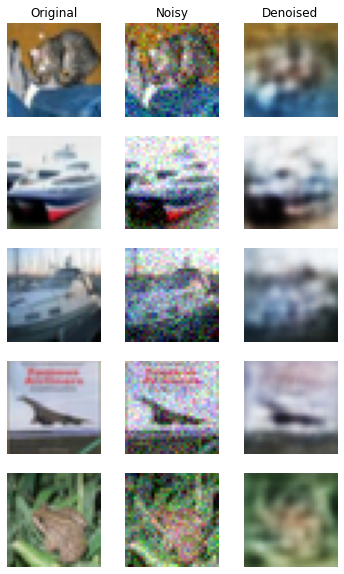

In [19]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [22]:
model = keras.models.Sequential([
    encoder,
    keras.layers.Dense(10, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=[X_test, y_test])

Epoch 1/10
 284/1563 [====>.........................] - ETA: 1:48 - loss: 1.8331 - accuracy: 0.3417

# 10

변이형 오토인코더를 훈련하고, 새로운 샘플을 생성해보시오.

In [30]:
(X_train,y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

In [2]:
class Sampling(keras.layers.Layer):
    #평균, 분산의 로그
    def call(self, inputs):
        mean, log_var = inputs
        #평균이 0, 표준편차가 1 인 정규분포에 표준편차를 곱하고, 평균을 더한다.
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [32]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z) 
#평균코딩층
codings_mean = keras.layers.Dense(codings_size)(z)
#log var 층
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


In [33]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [35]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = - 0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=1
)

variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[rounded_accuracy])

In [36]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=[X_test, X_test])

Epoch 1/25
469/469 [==============================] - 4s 6ms/step - loss: 0.3846 - rounded_accuracy: 0.8641 - val_loss: 0.3460 - val_rounded_accuracy: 0.8997
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3411 - rounded_accuracy: 0.8994 - val_loss: 0.3330 - val_rounded_accuracy: 0.9044
Epoch 3/25
469/469 [==============================] - 3s 5ms/step - loss: 0.3313 - rounded_accuracy: 0.9067 - val_loss: 0.3308 - val_rounded_accuracy: 0.9082
Epoch 4/25
469/469 [==============================] - 3s 5ms/step - loss: 0.3265 - rounded_accuracy: 0.9101 - val_loss: 0.3252 - val_rounded_accuracy: 0.9147
Epoch 5/25
469/469 [==============================] - 3s 5ms/step - loss: 0.3236 - rounded_accuracy: 0.9124 - val_loss: 0.3238 - val_rounded_accuracy: 0.9130
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3216 - rounded_accuracy: 0.9140 - val_loss: 0.3224 - val_rounded_accuracy: 0.9122
Epoch 7/25
469/469 [==============================] 

In [10]:
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")

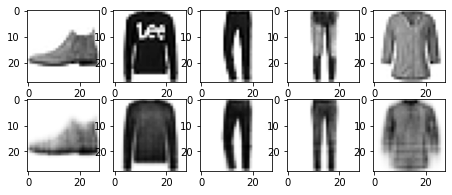

In [37]:
      
show_reconstructions(variational_ae)
plt.show()

In [5]:
codings_size = 40

inputs = keras.layers.Input(shape=[32, 32, 3])
z = keras.layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
z = keras.layers.Conv2D(48, kernel_size=3, activation='relu')(z)
z = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(z)
z = keras.layers.Conv2D(80, kernel_size=3, activation='relu')(z)
z = keras.layers.Conv2D(96, kernel_size=3, activation='relu')(z)
z = keras.layers.MaxPooling2D()(z)
z = keras.layers.Flatten()(z)
#평균코딩층
codings_mean = keras.layers.Dense(codings_size)(z)
#log var 층
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 48)   13872       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 26, 26, 64)   27712       ['conv2d_1[0][0]']               
                                                                                              

In [6]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
z = keras.layers.Dense(11*11*96, activation='relu')(decoder_inputs)
z = keras.layers.Reshape([11, 11, 96])(z)
z = keras.layers.Conv2DTranspose(96, kernel_size=3, strides=2, padding='same', activation='relu')(z)
z = keras.layers.Conv2DTranspose(80, kernel_size=3, padding='valid', activation='relu')(z)
z = keras.layers.Conv2DTranspose(64, kernel_size=3, padding='valid', activation='relu')(z)
z = keras.layers.Conv2DTranspose(48, kernel_size=3, padding='valid', activation='relu')(z)
z = keras.layers.Conv2DTranspose(32, kernel_size=3, padding='valid', activation='relu')(z)
z = keras.layers.Conv2DTranspose(3, kernel_size=3, padding='valid', activation='sigmoid')(z)

outputs = keras.layers.Reshape([32,32,3])(z)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
variational_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_2 (Dense)             (None, 11616)             476256    
                                                                 
 reshape (Reshape)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 22, 22, 96)       83040     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 24, 24, 80)       69200     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 26, 26, 64)       4614

In [7]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = - 0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=1
)

variational_ae.add_loss(K.mean(latent_loss))
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['mse', rounded_accuracy])

In [8]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train / 255.
X_test = X_test / 255.

history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=[X_test, X_test])

Epoch 1/25
391/391 [==============================] - 30s 51ms/step - loss: 0.6943 - mse: 0.0622 - rounded_accuracy: 0.5633 - val_loss: 0.6896 - val_mse: 0.0619 - val_rounded_accuracy: 0.5628
Epoch 2/25
391/391 [==============================] - 19s 50ms/step - loss: 0.6892 - mse: 0.0620 - rounded_accuracy: 0.5641 - val_loss: 0.6894 - val_mse: 0.0618 - val_rounded_accuracy: 0.5625
Epoch 3/25
391/391 [==============================] - 19s 50ms/step - loss: 0.6892 - mse: 0.0620 - rounded_accuracy: 0.5639 - val_loss: 0.6895 - val_mse: 0.0618 - val_rounded_accuracy: 0.5627
Epoch 4/25
391/391 [==============================] - 19s 50ms/step - loss: 0.6892 - mse: 0.0620 - rounded_accuracy: 0.5639 - val_loss: 0.6894 - val_mse: 0.0618 - val_rounded_accuracy: 0.5630
Epoch 5/25
391/391 [==============================] - 19s 49ms/step - loss: 0.6892 - mse: 0.0620 - rounded_accuracy: 0.5640 - val_loss: 0.6894 - val_mse: 0.0618 - val_rounded_accuracy: 0.5623
Epoch 6/25
391/391 [====================

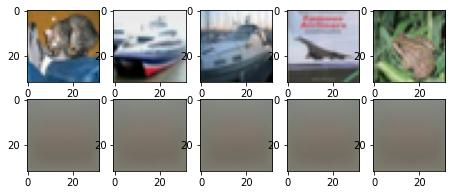

In [11]:
show_reconstructions(variational_ae, images=X_test)
plt.show()